<a href="https://colab.research.google.com/github/kwonbuyeon/2021-1_basicCarAI/blob/master/report3)_%EC%B0%A8%EC%84%A0_%EA%B2%80%EC%B6%9C_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**report3) 차선 검출 알고리즘**

권부연_20203030

차선검출 알고리즘을 활용하여
입력받은 동영상을 처리한 후 또 다른 동영상파일로 출력하는 코드입니다.




따로 준비된 동영상 파일이 없다면 test video를 아래 주소에서 받을 수 있습니다. 


> https://github.com/kwonbuyeon/2021-1_basicCarAI/tree/master/report3






본 코드에서는 입력 파일인 report3_testvideo.mp4의 경로를 /content/report3_testvideo.mp4 로 사용하였습니다.

출력되는 동영상의 경로는 /content/Segmented Video.avi 입니다.


----------------------


차선검출 코드를 가져옵니다.

In [155]:
!git clone https://github.com/Lhyejin/LaneNet-PyTorch.git

fatal: destination path 'LaneNet-PyTorch' already exists and is not an empty directory.


In [156]:
%cd LaneNet-PyTorch//
!ls
!pip install -r requirements.txt

/content/LaneNet-PyTorch/LaneNet-PyTorch/2021-1_basicCarAI/report3/2021-1_basicCarAI/LaneNet-PyTorch/LaneNet-PyTorch/LaneNet-PyTorch
dataset  LICENSE	      requirements.txt	Train.ipynb
img	 Notebook-experiment  test.py		TUSIMPLE
Lanenet  README.md	      Train_aug.ipynb	utils


차선 검출코드를 이용하여 입력받은 이미지를 차선이 검출된 이미지로 출력하는 함수입니다.

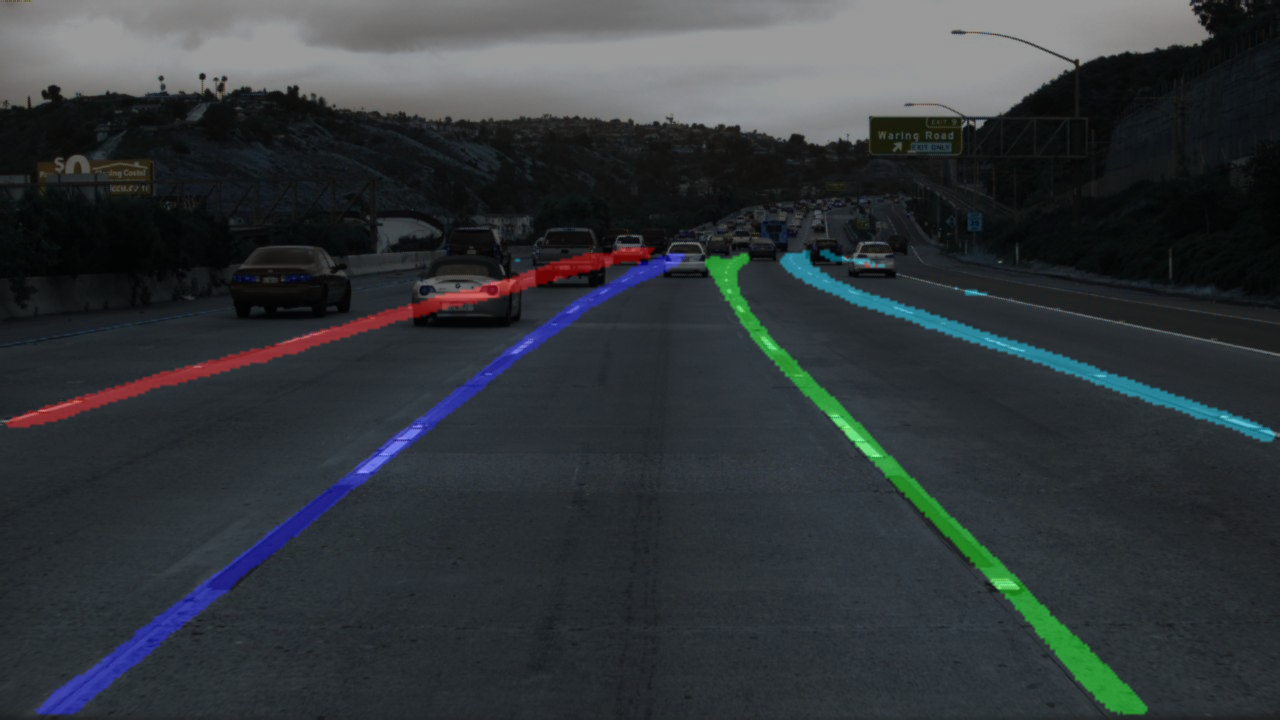

In [157]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
import os
import matplotlib.pylab as plt
import sys
from tqdm import tqdm
import imageio
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet
from utils.evaluation import gray_to_rgb_emb, process_instance_embedding
from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the Model
model_path = './TUSIMPLE/Lanenet_output/lanenet_epoch_39_batch_8.model'
LaneNet_model = Lanenet(2, 4)
LaneNet_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
LaneNet_model.to(device)

def inference(gt_img_org):
    # BGR 순서
    org_shape = gt_img_org.shape
    gt_image = cv2.resize(gt_img_org, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
    gt_image = gt_image / 127.5 - 1.0
    gt_image = torch.tensor(gt_image, dtype=torch.float)
    gt_image = np.transpose(gt_image, (2, 0, 1))
    gt_image = gt_image.to(device)
    # lane segmentation 
    binary_final_logits, instance_embedding = LaneNet_model(gt_image.unsqueeze(0))
    binary_final_logits, instance_embedding = binary_final_logits.to('cpu'), instance_embedding.to('cpu') 
    binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()
    binary_img[0:65,:] = 0

    # lane clustering & segemented frame embedding
    rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img,
                                                          distance=1.5, lane_num=4)

    rbg_emb = cv2.resize(rbg_emb, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_LINEAR)
    a = 0.6
    frame = a * gt_img_org[..., ::-1] / 255 + rbg_emb * (1 - a)
    frame = np.rint(frame * 255)
    frame = frame.astype(np.uint8)

    return frame


image = cv2.imread('TUSIMPLE/test_clips/1494452927854312215/1.jpg')
cv2_imshow(inference(image))

입력받은 비디오를 프레임단위로 나누어 차선검출한 후 다시 합쳐 Segmented Video.avi을 만드는 함수입니다.

In [158]:
def video2segemented_video(video_path):
    #load video
    video = cv2.VideoCapture(video_path)
    
    #setting video options (fps, width, height는 기존 영상과 같게 설정하였습니다.)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = video.get(cv2.CAP_PROP_FPS)
    width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    segVideo = cv2.VideoWriter("/content/Segmented Video.avi",fourcc,fps,(int(width), int(height)))

    #프레임 이미지 수정 및 저장
    while True :
        ret, frame = video.read()#프레임 이미지 가져오기 (ret : frame이 정산적으로 가져와졌는지, frame : 이미지)
        if not(ret):
            break
        image = inference(frame)#이미지에 차선 그리기
        #cv2_imshow(image)
        segVideo.write(image)#저장항 동영상으로 이미지넣기

    video.release()
    segVideo.release()
    print("Successfully Done! check the file 'Segmented Video.avi' in your folder")

main 입니다. 이곳에서 입력받을 비디오의 경로를 설정해주시면 됩니다.


현재 경로는 /content/report3_testvideo.mp4 입니다.




In [159]:
video_path = "/content/report3_testvideo.mp4" # input your video path
video2segemented_video(video_path)

Successfully Done! check the file 'Segmented Video.avi' in your folder


if()dskjd